# Prática com Python
1. Modelos clássicos
 - Regressão Linear
 - Regressão Logística
 - Support Vector Machine (SVM)
 - Árvore de decisão
 - Random Forests
 - K-means
2. Integração
 - Arquivos de texto
 - Bancos de dados
 - Data Mesh (AWS)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay,
                             precision_recall_curve, accuracy_score, f1_score, recall_score, precision_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedShuffleSplit, cross_validate,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, SVR
import pickle

In [2]:
SEED = 42
numbers = pd.read_csv("data/mnist.csv")
numbers.shape

(42000, 785)

# Divisão do conjunto

In [3]:
numbers.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

Campo `label` é o rótulo deste conjunto de dados, que desejo prever com o modelo.

In [4]:
def get_distribution(series: pd.Series) -> pd.DataFrame:
    counting = series.value_counts().sort_index()
    return pd.DataFrame([
        counting,
        counting / counting.sum()
    ],
    index=["count", "ratio"])

In [5]:
numbers_dist = get_distribution(numbers.label)
numbers_dist

label,0,1,2,3,4,5,6,7,8,9
count,4132.000000,4684.000000,4177.000000,4351.000000,4072.000000,3795.000000,4137.0000,4401.000000,4063.000000,4188.000000
ratio,0.098381,0.111524,0.099452,0.103595,0.096952,0.090357,0.0985,0.104786,0.096738,0.099714


<Axes: title={'center': 'Distribuição dos rótulos'}, ylabel='label'>

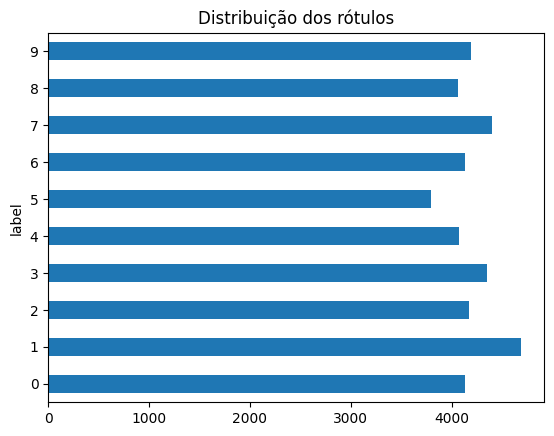

In [6]:
numbers_dist.loc["count"].plot(kind="barh", title="Distribuição dos rótulos")

## Divisão estratificada

In [7]:
splitter = StratifiedShuffleSplit(1, test_size=0.3, random_state=SEED)
((train_indexes, test_indexes),) = splitter.split(numbers, numbers.label)
train_indexes.shape, test_indexes.shape

((29400,), (12600,))

In [8]:
stratified_train_dist = get_distribution(numbers.label[train_indexes])
stratified_train_dist

label,0,1,2,3,4,5,6,7,8,9
count,2892.000000,3279.000000,2924.000000,3046.000000,2850.000000,2656.00000,2896.000000,3081.000000,2844.000000,2932.000000
ratio,0.098367,0.111531,0.099456,0.103605,0.096939,0.09034,0.098503,0.104796,0.096735,0.099728


In [9]:
def compare_distributions(left: pd.DataFrame, right: pd.DataFrame) -> pd.DataFrame:
    rate = right.T["count"].sum() / left.T["count"].sum() 
    return pd.DataFrame([
        (left.T["count"] * rate - right.T["count"]).round(),
        (left.T["count"] * rate - right.T["count"]).round() / left.T["count"].sum()
    ])

In [10]:
compare_distributions(numbers_dist, stratified_train_dist)

label,0,1,2,3,4,5,6,7,8,9
count,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
count,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0


Com o arredondamento, praticamente sem diferença nas distribuições.

## Divisão aleatória

In [11]:
train_numbers, test_numbers = train_test_split(numbers, test_size=0.3, random_state=SEED)
train_numbers.shape, test_numbers.shape

((29400, 785), (12600, 785))

In [12]:
random_train_dist = get_distribution(train_numbers.label)
random_train_dist

label,0,1,2,3,4,5,6,7,8,9
count,2932.000000,3295.000000,2883.000000,2996.000000,2850.000000,2710.000000,2881.000000,3042.000000,2854.000000,2957.000000
ratio,0.099728,0.112075,0.098061,0.101905,0.096939,0.092177,0.097993,0.103469,0.097075,0.100578


In [13]:
compare_distributions(numbers_dist, random_train_dist)

label,0,1,2,3,4,5,6,7,8,9
count,-40.000000,-16.000000,41.000000,50.00000,0.0,-54.000000,15.000000,39.000000,-10.000000,-25.000000
count,-0.000952,-0.000381,0.000976,0.00119,0.0,-0.001286,0.000357,0.000929,-0.000238,-0.000595


In [14]:
from hashlib import md5

Pequena diferença nas distribuições.  
Quanto maior o conjunto de dados e a quantidade de itens por rótulo, menor a diferença percentual.

## Divisão dos conjuntos por hash

In [15]:
digest_size = md5(b"").digest_size
max_hash = int("f" * digest_size * 2, 16)
max_hash

340282366920938463463374607431768211455

In [16]:
test_size = 0.3
hash_split = hex(int(max_hash * test_size))[2:]
hash_split

'4ccccccccccccc000000000000000000'

In [17]:
numbers_bytes = np.apply_along_axis(lambda x: x.tobytes(), axis=1, arr=numbers.to_numpy())
numbers_hashes = np.array([md5(x).hexdigest() for x in numbers_bytes])
train_filter = numbers_hashes > hash_split
train_hash_numbers = numbers[train_filter]
test_hash_numbers = numbers[~train_filter]
train_hash_numbers.shape, test_hash_numbers.shape

((29584, 785), (12416, 785))

In [18]:
train_hash_numbers.shape[0] / numbers.shape[0]

0.7043809523809523

In [19]:
train_hash_dist = get_distribution(train_hash_numbers.label)
train_hash_dist

label,0,1,2,3,4,5,6,7,8,9
count,2942.000000,3332.000000,2940.000000,3055.000000,2851.00000,2627.000000,2864.000000,3129.000000,2872.00000,2972.00000
ratio,0.099446,0.112628,0.099378,0.103265,0.09637,0.088798,0.096809,0.105767,0.09708,0.10046


In [20]:
compare_distributions(numbers_dist, train_hash_dist)

label,0,1,2,3,4,5,6,7,8,9
count,-31.000000,-33.000000,2.000000,10.000000,17.000000,46.000000,50.00000,-29.00000,-10.000000,-22.000000
count,-0.000738,-0.000786,0.000048,0.000238,0.000405,0.001095,0.00119,-0.00069,-0.000238,-0.000524


Fácil de adicionar novos dados na base sem misturar dados de treino e dados de teste.

# Divisão dos conjuntos de treino e teste

In [21]:
targets = ["label"]
train, test = train_hash_numbers, test_hash_numbers
filter_fields = train.columns.isin(targets)
x, y = train.loc[:, ~filter_fields], train.loc[:, filter_fields]
test_x, test_y = test.loc[:, ~filter_fields], test.loc[:, filter_fields]
x.shape, y.shape

((29584, 784), (29584, 1))

## Bases de dados desbalanceadas

In [22]:
labels = list()
labels_counts = y["label"].value_counts()
for label in range(10):
    filtered_numbers = y[y["label"] == label]
    labels.append(filtered_numbers.sample(labels_counts.min(), replace=False, random_state=SEED))
numbers_downsample = pd.concat(labels, axis=0)

In [23]:
labels = list()
labels_counts = y["label"].value_counts()
for label in range(10):
    filtered_numbers = y[y["label"] == label]
    labels.append(filtered_numbers.sample(labels_counts.max(), replace=True, random_state=SEED))
numbers_upsample = pd.concat(labels, axis=0)

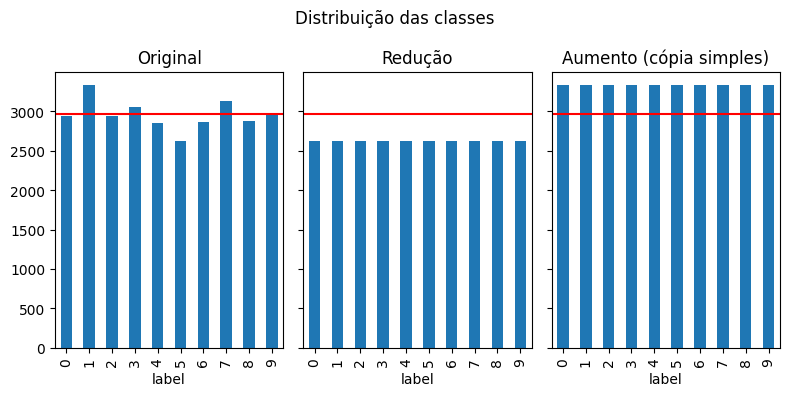

In [24]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8, 4))
y.label.value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Original")
numbers_downsample.label.value_counts().sort_index().plot(kind="bar", ax=axes[1], title="Redução")
numbers_upsample.label.value_counts().sort_index().plot(kind="bar", ax=axes[2], title="Aumento (cópia simples)")
for ax in axes:
    ax.axhline(y.shape[0] / 10, c="r")
fig.suptitle("Distribuição das classes")
fig.tight_layout()
plt.show()

In [25]:
base_reference_model = LogisticRegression(random_state=SEED)
cv_result = cross_validate(base_reference_model, x, y.label, cv=5, return_estimator=True)
reference_model = cv_result["estimator"][cv_result["test_score"].argmax()]

/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [26]:
downsample_x = x.loc[numbers_downsample.index]
downsample_y = y.loc[numbers_downsample.index]
base_reference_model = LogisticRegression(random_state=SEED)
cv_result = cross_validate(base_reference_model, downsample_x, downsample_y.label, cv=5, return_estimator=True)
downsample_model = cv_result["estimator"][cv_result["test_score"].argmax()]

/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [27]:
upsample_x = x.loc[numbers_upsample.index]
upsample_y = y.loc[numbers_upsample.index]
base_reference_model = LogisticRegression(random_state=SEED)
cv_result = cross_validate(base_reference_model, upsample_x, upsample_y.label, cv=5, return_estimator=True)
upsample_model = cv_result["estimator"][cv_result["test_score"].argmax()]

/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [28]:
np.array((reference_model.score(x, y), downsample_model.score(x, y), upsample_model.score(x, y))).round(4)

array([0.9378, 0.9364, 0.9292])

In [29]:
np.array((reference_model.score(test_x, test_y), downsample_model.score(test_x, test_y), upsample_model.score(test_x, test_y)),).round(4)

array([0.9096, 0.9079, 0.8971])

In [30]:
base_reference_model = LogisticRegression(random_state=SEED, class_weight="balanced")
cv_result = cross_validate(base_reference_model, x, y.label, cv=5, return_estimator=True)
balanced_model = cv_result["estimator"][cv_result["test_score"].argmax()]

/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mascote/miniconda3/envs/workshop/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [31]:
np.array((balanced_model.score(x, y), balanced_model.score(test_x, test_y))).round(4)

array([0.9389, 0.9093])

In [32]:
y_pred = reference_model.predict(x)
pd.DataFrame([precision_score(y, y_pred, average=None), recall_score(y, y_pred, average=None), f1_score(y, y_pred, average=None)], index=["Precisão", "Recall", "F1"]).T

,Precisão,Recall,F1
0,0.968003,0.976886,0.972424
1,0.969130,0.979892,0.974481
2,0.939734,0.912245,0.925785
3,0.918253,0.915548,0.916899
4,0.937478,0.946685,0.942059
5,0.913060,0.899505,0.906232
6,0.959212,0.968925,0.964044
7,0.942631,0.950463,0.946531
8,0.899035,0.908426,0.903706
9,0.923523,0.910162,0.916794


In [33]:
y_pred = balanced_model.predict(x)
pd.DataFrame([precision_score(y, y_pred, average=None), recall_score(y, y_pred, average=None), f1_score(y, y_pred, average=None)], index=["Precisão", "Recall", "F1"]).T

,Precisão,Recall,F1
0,0.969003,0.977566,0.973266
1,0.970544,0.978992,0.974750
2,0.936546,0.918707,0.927541
3,0.923254,0.917512,0.920374
4,0.942787,0.942126,0.942456
5,0.910099,0.905596,0.907842
6,0.959585,0.969972,0.964751
7,0.949583,0.945030,0.947301
8,0.905977,0.902507,0.904239
9,0.913724,0.922948,0.918313


## Métricas de classificação

\begin{equation}
Acurácia = \frac{Acertos}{Total}
\end{equation}

\begin{equation}
Precisão = \frac{VP}{VP + FP}
\end{equation}

\begin{equation}
Recall = \frac{VP}{VP + FN}
\end{equation}

\begin{equation}
F1 = \frac{Precisão + Recall}{2}
\end{equation}

Text(0.5, 0.98, 'Matriz de confusão')

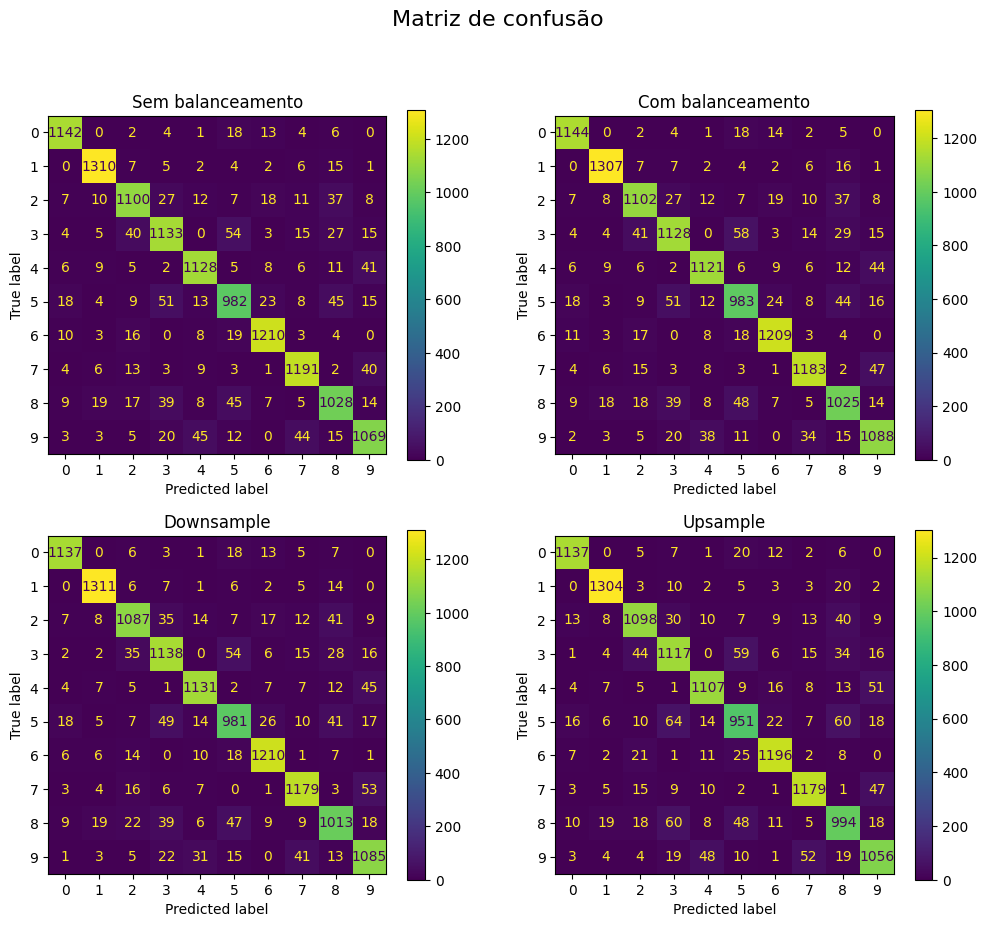

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ConfusionMatrixDisplay.from_estimator(reference_model, test_x, test_y, ax=axes[0][0])
ConfusionMatrixDisplay.from_estimator(balanced_model, test_x, test_y, ax=axes[0][1])
ConfusionMatrixDisplay.from_estimator(downsample_model, test_x, test_y, ax=axes[1][0])
ConfusionMatrixDisplay.from_estimator(upsample_model, test_x, test_y, ax=axes[1][1])
axes[0][0].title.set_text("Sem balanceamento")
axes[0][1].title.set_text("Com balanceamento")
axes[1][0].title.set_text("Downsample")
axes[1][1].title.set_text("Upsample")
fig.suptitle("Matriz de confusão", size=16)

# Classificadores

In [35]:
kmeans = KMeans(10, random_state=SEED)
best_kmeans = kmeans.fit(x)
svc = SVC(random_state=SEED, probability=True)
cv_result = cross_validate(svc, x.iloc[:5000], y.label.iloc[:5000], cv=3, return_estimator=True)
best_svc = cv_result["estimator"][cv_result["test_score"].argmax()]
tree = DecisionTreeClassifier(random_state=SEED, )
cv_result = cross_validate(tree, x, y.label, cv=3, return_estimator=True)
best_tree = cv_result["estimator"][cv_result["test_score"].argmax()]

array([7], dtype=int32)

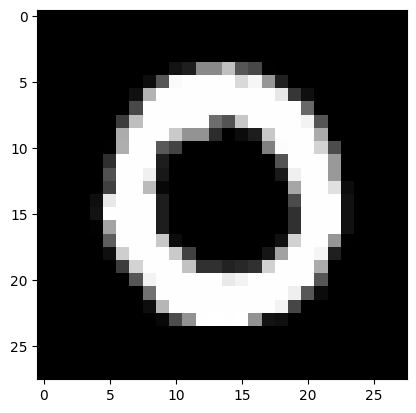

In [36]:
i = 0
y_pred = best_kmeans.predict(x.iloc[[i]])
plt.imshow(x.iloc[i].to_numpy().reshape(28, 28), cmap="gray")
y_pred

In [37]:
y_pred = best_tree.predict(x)
pd.DataFrame([precision_score(y, y_pred, average=None), recall_score(y, y_pred, average=None), f1_score(y, y_pred, average=None)], index=["Precisão", "Recall", "F1"]).T

,Precisão,Recall,F1
0,0.970388,0.969069,0.969728
1,0.965966,0.979592,0.972731
2,0.935770,0.931633,0.933697
3,0.929698,0.926350,0.928021
4,0.944367,0.946685,0.945525
5,0.926829,0.925771,0.926300
6,0.961281,0.953561,0.957406
7,0.951899,0.961329,0.956591
8,0.932155,0.918524,0.925289
9,0.934965,0.938425,0.936692


In [38]:
y_pred = best_svc.predict(x)
pd.DataFrame([precision_score(y, y_pred, average=None), recall_score(y, y_pred, average=None), f1_score(y, y_pred, average=None)], index=["Precisão", "Recall", "F1"]).T

,Precisão,Recall,F1
0,0.963160,0.986404,0.974643
1,0.963115,0.987395,0.975104
2,0.948300,0.929592,0.938853
3,0.941118,0.926023,0.933509
4,0.941299,0.950544,0.945899
5,0.935825,0.943662,0.939727
6,0.955403,0.972416,0.963835
7,0.953841,0.944391,0.949093
8,0.936812,0.918872,0.927755
9,0.934685,0.914872,0.924673


In [39]:
rf = RandomForestClassifier(random_state=SEED,)
cv_result = cross_validate(rf, x, y.label, cv=3, return_estimator=True)
best_rf = cv_result["estimator"][cv_result["test_score"].argmax()]
y_pred = best_rf.predict(x)
pd.DataFrame([precision_score(y, y_pred, average=None), recall_score(y, y_pred, average=None), f1_score(y, y_pred, average=None)], index=["Precisão", "Recall", "F1"]).T

,Precisão,Recall,F1
0,0.989186,0.994901,0.992035
1,0.991346,0.996999,0.994164
2,0.984417,0.988435,0.986422
3,0.983273,0.981342,0.982307
4,0.988736,0.985268,0.986999
5,0.989276,0.983251,0.986254
6,0.991277,0.991969,0.991623
7,0.990067,0.987536,0.988800
8,0.981217,0.982242,0.981730
9,0.980061,0.975774,0.977913


In [40]:
with open("models/reference_model.pkl", "wb") as f:
    pickle.dump(reference_model, f)
with open("models/balanced_model.pkl", "wb") as f:
    pickle.dump(balanced_model, f)
with open("models/best_tree.pkl", "wb") as f:
    pickle.dump(best_tree, f)
with open("models/best_svc.pkl", "wb") as f:
    pickle.dump(best_svc, f)
with open("models/best_rf.pkl", "wb") as f:
    pickle.dump(best_rf, f)

# Próximos passos
- Identificar o porquê dos erros
- Incluir classe que não representam números